# Part I.III - Obtain Google Play Reviews

In [1]:
## Import necessary libraries

# retrieves app info AND reviews from Google Play
from google_play_scraper import app, Sort, reviews, reviews_all

# pretty print data structures
from pprint import pprint

# for storing in MongoDB
import pymongo
from pymongo import MongoClient

import datetime as dt
from tzlocal import get_localzone

import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
## Read in file containing app details, 
  ## need the app IDs for scraping stores
app_df = pd.read_csv('Data/mha_app_info.csv')
app_df.head()

,app_name,iOS,iOS_revs,iOS_app_name,iOS_app_id,android,android_revs,android_appID
0,Aloe Bud,1,3000,aloe-bud,1318382054,0,0,NaN
1,Aura,1,22100,aura-meditation-sleep,1114223104,1,10400,com.aurahealth
2,BetterHelp,1,32400,betterhelp-online-counseling,995252384,1,15300,com.betterhelp
3,Breathe2Relax,1,200,breathe2relax,425720246,1,1100,org.t2health.breathe2relax
4,Breathwrk: Breathing Exercises,1,10400,breathwrk,1481804500,0,0,NaN


In [3]:
## Store list of app ids and names to loop through for Google Play
google_play_apps = app_df.copy()
google_play_apps = google_play_apps.loc[google_play_apps['android']==1]

google_play_names = list(google_play_apps['app_name'])
google_play_ids = list(google_play_apps['android_appID'])

In [4]:
## Check number of apps found in Google Play
len(google_play_ids)

53

## Set Up MongoDB for Project

In [5]:
## Set up Mongo client
client = MongoClient(host='localhost', port=27018)

In [6]:
## Database for project
mha_proj_db = client['mha_proj_db']

In [7]:
## Set up new collection within project db
google_play_rvws = mha_proj_db['google_play_rvws']

In [8]:
# google_play_rvws.drop()

## Scrape Reviews from Google Play

In [10]:
## Loop through apps to get reviews
for app_name, app_id in zip(google_play_names, google_play_ids):
    
    # Get start time
    start = dt.datetime.now(tz=get_localzone())
    fmt= "%m/%d/%y - %T %p"    
    
    # Print starting output for app
    print('---'*20)
    print('---'*20)    
    print(f'***** {app_name} started at {start.strftime(fmt)}')
    print()
    
    # Empty list for storing reviews
    app_reviews = []
    
    # Number of reviews to scrape per batch
    count = 200
    
    # To keep track of how many batches have been completed
    batch_num = 0
    
    
    # Retrieve reviews (and continuation_token) with reviews function
    rvws, token = reviews(
        app_id,           # found in app's url
        lang='en',        # defaults to 'en'
        country='us',     # defaults to 'us'
        sort=Sort.NEWEST, # start with most recent
        count=count       # batch size
    )
    
    
    # For each review obtained
    for r in rvws:
        r['app_name'] = app_name # add key for app's name
        r['app_id'] = app_id     # add key for app's id
     
    
    # Add the list of review dicts to overall list
    app_reviews.extend(rvws)
    
    # Increase batch count by one
    batch_num +=1 
    print(f'Batch {batch_num} completed.')
    
    # Wait 1 to 5 seconds to start next batch
    time.sleep(random.randint(20,30))
    
    
    
    # Append review IDs to list prior to starting next batch
    pre_review_ids = []
    for rvw in app_reviews:
        pre_review_ids.append(rvw['reviewId'])
    
    
    # Loop through at most max number of batches
    for batch in range(4999):
        rvws, token = reviews( # store continuation_token
            app_id,
            lang='en',
            country='us',
            sort=Sort.NEWEST,
            count=count,
            # using token obtained from previous batch
            continuation_token=token
        )
        
        # Append unique review IDs from current batch to new list
        new_review_ids = []
        for r in rvws:
            new_review_ids.append(r['reviewId'])
            
            # And add keys for name and id to ea review dict
            r['app_name'] = app_name # add key for app's name
            r['app_id'] = app_id     # add key for app's id
     
        # Add the list of review dicts to main app_reviews list
        app_reviews.extend(rvws)
        
        # Increase batch count by one
        batch_num +=1
        
        # Break loop and stop scraping for current app if most recent batch
          # did not add any unique reviews
        all_review_ids = pre_review_ids + new_review_ids
        if len(set(pre_review_ids)) == len(set(all_review_ids)):
            print(f'No reviews left to scrape. Completed {batch_num} batches.\n')
            break
        
        # all_review_ids becomes pre_review_ids to check against 
          # for next batch
        pre_review_ids = all_review_ids
        
        
        # At every 100th batch
        if batch_num%100==0:
            
            # print update on number of batches
            print(f'Batch {batch_num} completed.')
            
            # insert reviews into collection
            google_play_rvws.insert_many(app_reviews)
            
            # print update about num reviews inserted
            store_time = dt.datetime.now(tz=get_localzone())
            print(f"""
            Successfully inserted {len(app_reviews)} {app_name} 
            reviews into collection at {store_time.strftime(fmt)}.\n
            """)
            
            # empty our list for next round of 100 batches
            app_reviews = []
        
        # Wait 1 to 5 seconds to start next batch
        time.sleep(random.randint(1,5))
      
    
    # Print update when max number of batches has been reached
      # OR when last batch didn't add any unique reviews
    print(f'Done scraping {app_name}.')
    print(f'Scraped a total of {len(set(pre_review_ids))} unique reviews.\n')
    
    
    # Insert remaining reviews into collection
    google_play_rvws.insert_many(app_reviews)
    
    # Get end time
    end = dt.datetime.now(tz=get_localzone())
    
    # Print ending output for app
    print(f"""
    Successfully inserted all {app_name} reviews into collection
    at {end.strftime(fmt)}.\n
    """)
    print(f'Time elapsed for {app_name}: {end-start}')
    print('---'*20)
    print('---'*20)
    print('\n')
    
    # Wait 1 to 5 seconds to start scraping next app
    time.sleep(random.randint(1,5))

------------------------------------------------------------
------------------------------------------------------------
***** Aura started at 03/24/21 - 08:07:07 AM

Batch 1 completed.
No reviews left to scrape. Completed 16 batches.

Done scraping Aura.
Scraped a total of 2892 unique reviews.


    Successfully inserted all Aura reviews into collection
    at 03/24/21 - 08:08:38 AM.

    
Time elapsed for Aura: 0:01:30.331102
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------
***** BetterHelp started at 03/24/21 - 08:08:40 AM

Batch 1 completed.
No reviews left to scrape. Completed 27 batches.

Done scraping BetterHelp.
Scraped a total of 5117 unique reviews.


    Successfully inserted all BetterHelp reviews into collection
    at 03/24/21 - 08:10:31 AM.

    
Time elapsed for BetterHelp: 0

------------------------------------------------------------
------------------------------------------------------------
***** GG Self Care started at 03/24/21 - 09:17:56 AM

Batch 1 completed.
No reviews left to scrape. Completed 2 batches.

Done scraping GG Self Care.
Scraped a total of 16 unique reviews.


    Successfully inserted all GG Self Care reviews into collection
    at 03/24/21 - 09:18:17 AM.

    
Time elapsed for GG Self Care: 0:00:20.460836
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------
***** GG Self Esteem started at 03/24/21 - 09:18:21 AM

Batch 1 completed.
No reviews left to scrape. Completed 2 batches.

Done scraping GG Self Esteem.
Scraped a total of 140 unique reviews.


    Successfully inserted all GG Self Esteem reviews into collection
    at 03/24/21 - 09:18:50 A

Batch 1 completed.
No reviews left to scrape. Completed 11 batches.

Done scraping Meditopia: Meditation Coach.
Scraped a total of 1963 unique reviews.


    Successfully inserted all Meditopia: Meditation Coach reviews into collection
    at 03/24/21 - 09:59:59 AM.

    
Time elapsed for Meditopia: Meditation Coach: 0:01:09.868200
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------
***** MindDoc started at 03/24/21 - 10:00:00 AM

Batch 1 completed.
No reviews left to scrape. Completed 40 batches.

Done scraping MindDoc.
Scraped a total of 7667 unique reviews.


    Successfully inserted all MindDoc reviews into collection
    at 03/24/21 - 10:02:50 AM.

    
Time elapsed for MindDoc: 0:02:50.805281
------------------------------------------------------------
------------------------------------

Batch 1 completed.
No reviews left to scrape. Completed 19 batches.

Done scraping Shine.
Scraped a total of 3458 unique reviews.


    Successfully inserted all Shine reviews into collection
    at 03/24/21 - 10:21:57 AM.

    
Time elapsed for Shine: 0:01:24.653236
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------
***** Smiling Mind started at 03/24/21 - 10:22:02 AM

Batch 1 completed.
No reviews left to scrape. Completed 9 batches.

Done scraping Smiling Mind.
Scraped a total of 1566 unique reviews.


    Successfully inserted all Smiling Mind reviews into collection
    at 03/24/21 - 10:23:02 AM.

    
Time elapsed for Smiling Mind: 0:00:59.879870
------------------------------------------------------------
------------------------------------------------------------


--------------------

### Initial Exploration of Google Play Reviews

In [11]:
## Query collection to get DataFrame with all reviews
gp_rvw_df = pd.DataFrame(list(google_play_rvws.find({})))
gp_rvw_df.head()

,_id,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,app_id
0,605b2bc5212470a175e95299,gp:AOqpTOGEfB5SuxUR45DJRzXJ13FFXszz7sHe0-EHZg9...,Melanie Loya,https://play-lh.googleusercontent.com/a-/AOh14...,Awesome,5,0,2.4.2,2021-03-22 05:59:22,Thanks for taking out time to rate us. It real...,2021-03-23 20:30:23,Aura,com.aurahealth
1,605b2bc5212470a175e9529a,gp:AOqpTOEN7u1-0qBPlPuUQOydnhZucb7zs5I4edD6-7r...,Deb Perez,https://play-lh.googleusercontent.com/-jQ70Y4S...,Great to help u sleep,5,0,2.4.2,2021-03-21 20:29:44,Thank you for your feedback. Glad to hear that...,2021-03-23 20:29:17,Aura,com.aurahealth
2,605b2bc5212470a175e9529b,gp:AOqpTOHckNKYL0-HbSxg7mzO7YjQJ73fGmlpcW-H4uX...,Zvon Davis,https://play-lh.googleusercontent.com/-cjE-8ul...,"Very calming, love it!",5,0,2.4.2,2021-03-21 09:17:13,Glad you like it! :) Thanks for your review!,2021-03-23 20:27:04,Aura,com.aurahealth
3,605b2bc5212470a175e9529c,gp:AOqpTOHx1iKm-H5IA8Rn7GDMz72FNxb2SHEJs0HcKkA...,Mary Ellen Gambon,https://play-lh.googleusercontent.com/a-/AOh14...,I was able to sleep like a baby on the first u...,5,0,2.4.2,2021-03-21 09:09:57,We are pleased that you enjoyed the app. If th...,2021-03-23 20:26:24,Aura,com.aurahealth
4,605b2bc5212470a175e9529d,gp:AOqpTOGA3muyUwk8gsdm92NYEy4R9L88BGaJLaC571U...,Amie Sandlin,https://play-lh.googleusercontent.com/a-/AOh14...,"Improvement in thoughts, feelings and life!",5,0,2.4.2,2021-03-20 16:28:42,Thank you for your review. Enjoy using the app...,2021-03-23 20:30:04,Aura,com.aurahealth


In [12]:
## Check total number of reviews scraped and stored in collection
len(gp_rvw_df)

431908

In [13]:
## Check number of unique reviews stored in collection
gp_rvw_df['reviewId'].nunique()

421583

In [14]:
## Total of 10325 duplicate reviews in collection
len(gp_rvw_df) - gp_rvw_df['reviewId'].nunique()

10325

In [15]:
## Drop duplicate reviews
gp_rvw_df = gp_rvw_df.drop(columns=['_id'])
gp_rvw_df = gp_rvw_df.drop_duplicates(['reviewId'])
print(len(gp_rvw_df))
gp_rvw_df['reviewId'].nunique()

421583


421583

In [17]:
## Also save df to csv
# gp_rvw_df.to_csv('Data/google_play_rvws.csv', index=False)

In [18]:
pd.read_csv('Data/google_play_rvws.csv')

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,app_id
0,gp:AOqpTOGEfB5SuxUR45DJRzXJ13FFXszz7sHe0-EHZg9...,Melanie Loya,https://play-lh.googleusercontent.com/a-/AOh14...,Awesome,5,0,2.4.2,2021-03-22 05:59:22,Thanks for taking out time to rate us. It real...,2021-03-23 20:30:23,Aura,com.aurahealth
1,gp:AOqpTOEN7u1-0qBPlPuUQOydnhZucb7zs5I4edD6-7r...,Deb Perez,https://play-lh.googleusercontent.com/-jQ70Y4S...,Great to help u sleep,5,0,2.4.2,2021-03-21 20:29:44,Thank you for your feedback. Glad to hear that...,2021-03-23 20:29:17,Aura,com.aurahealth
2,gp:AOqpTOHckNKYL0-HbSxg7mzO7YjQJ73fGmlpcW-H4uX...,Zvon Davis,https://play-lh.googleusercontent.com/-cjE-8ul...,"Very calming, love it!",5,0,2.4.2,2021-03-21 09:17:13,Glad you like it! :) Thanks for your review!,2021-03-23 20:27:04,Aura,com.aurahealth
3,gp:AOqpTOHx1iKm-H5IA8Rn7GDMz72FNxb2SHEJs0HcKkA...,Mary Ellen Gambon,https://play-lh.googleusercontent.com/a-/AOh14...,I was able to sleep like a baby on the first u...,5,0,2.4.2,2021-03-21 09:09:57,We are pleased that you enjoyed the app. If th...,2021-03-23 20:26:24,Aura,com.aurahealth
4,gp:AOqpTOGA3muyUwk8gsdm92NYEy4R9L88BGaJLaC571U...,Amie Sandlin,https://play-lh.googleusercontent.com/a-/AOh14...,"Improvement in thoughts, feelings and life!",5,0,2.4.2,2021-03-20 16:28:42,Thank you for your review. Enjoy using the app...,2021-03-23 20:30:04,Aura,com.aurahealth
...,...,...,...,...,...,...,...,...,...,...,...,...
421578,gp:AOqpTOHj3wM0-mJxNg3DGPRoUbq8A8q8fGjtBf8G-tP...,palwinder Singh wadali,https://play-lh.googleusercontent.com/a-/AOh14...,Loved it,5,0,NaN,2016-10-28 02:31:14,NaN,NaN,Wysa,bot.touchkin
421579,gp:AOqpTOHXIS7_gR1Soe1VYl6zXQ7UeOZDuAj1ftclfzb...,shampa singh,https://play-lh.googleusercontent.com/a-/AOh14...,Sometimes we just need a ear or sometimes the ...,5,2,0.1.6,2016-10-24 08:14:25,NaN,NaN,Wysa,bot.touchkin
421580,gp:AOqpTOEPiEXyZn-UjBu_J5LmdF2TY9XCigYmvTwtUL6...,Swami Nathan,https://play-lh.googleusercontent.com/a-/AOh14...,"Innovative thinking,... feeling good while int...",5,0,0.1.5,2016-10-16 11:03:57,NaN,NaN,Wysa,bot.touchkin
421581,gp:AOqpTOHQEuLNWcKhTAFMl4JJFBeqjXZ4aFOCPhurxz0...,Amulya Singh,https://play-lh.googleusercontent.com/a-/AOh14...,Great concept,5,2,NaN,2016-10-12 12:31:21,NaN,NaN,Wysa,bot.touchkin


In [24]:
client.close()

In [19]:
## Check number of reviews of each score
gp_rvw_df['score'].value_counts()

5    299787
4     50742
1     41445
3     17147
2     12458
0         4
Name: score, dtype: int64

In [20]:
## Investigate reviews with score of 0
gp_rvw_df.loc[gp_rvw_df['score']==0]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,app_id
136599,lg:AOqpTOGsj_LVg67dhWdCAq9tKTZc0-0XEVJg2XDecQk...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Is there a way to use this app for two people?...,0,0,1.0,2011-02-03 22:06:42,None,NaT,eMoods,my.tracker
136617,lg:AOqpTOEGU8eCnOPE2e4R9OySOzvjPBpxOjOzkNLBLqI...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Would be nice to have a symbol for the levels ...,0,0,1.0,2010-12-18 21:32:30,None,NaT,eMoods,my.tracker
302669,lg:AOqpTOHuDt_mvw1uaEczz0mR-0TesuygXb4QTtzmS6-...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Mindfully magnificent _/|\_,0,0,8.3.2,2012-05-03 19:50:18,None,NaT,Insight Timer,com.spotlightsix.zentimerlite2
302770,lg:AOqpTOF-aG0BhkhdpKEL6V_yHtV6KQAtSqb-AYH2LH4...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Exactly as described. Thanks.,0,0,8.3.1,2011-02-14 21:44:42,None,NaT,Insight Timer,com.spotlightsix.zentimerlite2


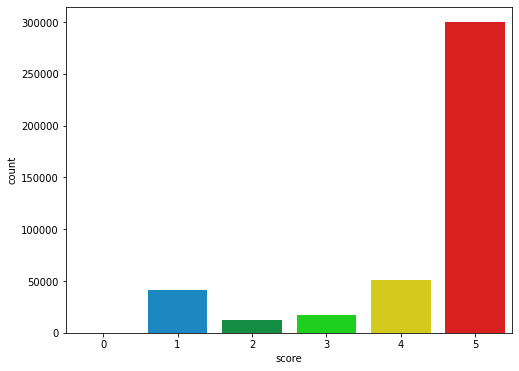

In [21]:
## Plot distribution of review scores
plt.figure(figsize=(8,6))
g = sns.countplot(data=gp_rvw_df, x='score', palette='nipy_spectral');

In [22]:
## Check which apps had so many reviews that they were
  ## so new that earliest review 
  ## doesn't go all the way back to March 2020
for app in gp_rvw_df['app_name'].unique():
    
    earliest_rvw = min(gp_rvw_df.loc[gp_rvw_df['app_name']==app]['at'])
    
    if earliest_rvw > dt.datetime(2020, 2, 28): 
    
        print(f"""Earliest review for {app}: 
            {min(gp_rvw_df.loc[gp_rvw_df['app_name']==app]['at'])}\n""")

Earliest review for GG Self Care: 
            2020-03-20 23:44:00



In [23]:
temp_list = []

for app in gp_rvw_df['app_name'].unique():
    
    app_slice = gp_rvw_df.loc[gp_rvw_df['app_name']==app].copy()
    
    cutoff_date = dt.datetime(2020, 2, 28)
    
    total_count = len(app_slice)
    
    count_from_Mar2020 = len(app_slice.loc[app_slice['at']>cutoff_date])
    
    earliest_rvw = min(app_slice['at'])
    
    temp_dict = {}
    temp_dict['app_name'] = app
    temp_dict['total_rvws'] = total_count
    temp_dict['rvws_since_Mar2020'] = count_from_Mar2020
    temp_dict['earliest_rvw'] = earliest_rvw
    
    temp_list.append(temp_dict)
    
app_Mar2020 = pd.DataFrame(temp_list)
app_Mar2020

,app_name,total_rvws,rvws_since_Mar2020,earliest_rvw
0,Aura,2892,849,2017-03-21 19:33:22
1,BetterHelp,5117,2340,2014-11-21 16:39:51
2,Breathe2Relax,304,33,2011-12-23 15:20:52
3,Breethe: Meditation & Sleep,1131,381,2016-01-26 14:16:12
4,Calm,79008,18578,2014-08-01 03:05:55
5,CBT Thought Diary,762,500,2014-07-08 08:59:50
6,Daylio,43860,4956,2015-08-21 05:07:56
7,DBT Coach,335,178,2019-03-06 15:48:18
8,eMoods,1631,88,2010-10-13 08:57:44
9,eQuoo: Emotional Fitness Game,1357,664,2017-12-26 15:12:59


In [25]:
client.close()